# IOT và Ứng Dụng

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn import preprocessing
import glob


In [2]:
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.svm import SVC

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier #Gradient Boosting Classifier

In [7]:
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

### Defining functions to load files and downsample them

##### Vì nghiên cứu này nhằm mục đích phát triển bộ phát hiện nhị phân (Tấn công hoặc Bình thường), chúng ta cân bằng tập dữ liệu giữa hai lớp này. Tuy nhiên, CIC-DDOS2019 có ít quy trình bình thường trong đó. Vì vậy, downsampling là cần thiết.

Đối với quy trình lấy mẫu xuống, chúng tôi cho phép các luồng dị thường lớn hơn "nhiều" lần so với các luồng bình thường. Cách tiếp cận này nhằm mục đích giảm sự mất cân bằng của lớp đồng thời ngăn chặn tổn thất thông tin trên các luồng tấn công (khi số lượng luồng tấn công được lấy mẫu xuống bằng số luồng bình thường, các mô hình ML không thể điều chỉnh phù hợp)

In [8]:
# mult = 5

# def load_file(path):
#     data = pd.read_csv(path, sep=',')

#     is_benign = data[' Label']=='BENIGN'
#     flows_ok = data[is_benign]
#     flows_ddos_full = data[~is_benign]
    
#     sizeDownSample = len(flows_ok)*mult # tamanho do set final de dados anomalos
    
#     # downsample majority
#     if (len(flows_ok)*mult) < (len(flows_ddos_full)): 
#         flows_ddos_reduced = resample(flows_ddos_full,
#                                          replace = False, # sample without replacement
#                                          n_samples = sizeDownSample, # match minority n
#                                          random_state = 27) # reproducible results
#     else:
#         flows_ddos_reduced = flows_ddos_full
    
#     return flows_ok, flows_ddos_reduced

 
# def load_huge_file(path):
#     df_chunk = pd.read_csv(path, chunksize=500000)
    
#     chunk_list_ok = []  # append each chunk df here 
#     chunk_list_ddos = [] 

#     # Each chunk is in df format
#     for chunk in df_chunk:  
#         # perform data filtering 
#         is_benign = chunk[' Label']=='BENIGN'
#         flows_ok = chunk[is_benign]
#         flows_ddos_full = chunk[~is_benign]
        
#         if (len(flows_ok)*mult) < (len(flows_ddos_full)): 
#             sizeDownSample = len(flows_ok)*mult # tamanho do set final de dados anomalos
            
#             # downsample majority
#             flows_ddos_reduced = resample(flows_ddos_full,
#                                              replace = False, # sample without replacement
#                                              n_samples = sizeDownSample, # match minority n
#                                              random_state = 27) # reproducible results 
#         else:
#             flows_ddos_reduced = flows_ddos_full
            
#         # Once the data filtering is done, append the chunk to list
#         chunk_list_ok.append(flows_ok)
#         chunk_list_ddos.append(flows_ddos_reduced)
        
#     # concat the list into dataframe 
#     flows_ok = pd.concat(chunk_list_ok)
#     flows_ddos = pd.concat(chunk_list_ddos)
    
#     return flows_ok, flows_ddos
  

In [9]:
# # file 1
# flows_ok, flows_ddos = load_file('03-11/LDAP.csv')
# print('file 1 loaded')

# # file 2
# a,b = load_file('03-11/MSSQL.csv')
# flows_ok = flows_ok.append(a,ignore_index=True)
# flows_ddos = flows_ddos.append(b,ignore_index=True)
# print('file 2 loaded')

# # file 3
# a,b = load_file('03-11/NetBIOS.csv')
# flows_ok = flows_ok.append(a,ignore_index=True)
# flows_ddos = flows_ddos.append(b,ignore_index=True)
# print('file 3 loaded')

# # file 4
# a,b = load_file('03-11/PortMap.csv')
# flows_ok = flows_ok.append(a,ignore_index=True)
# flows_ddos = flows_ddos.append(b,ignore_index=True)
# print('file 4 loaded')

# # file 5
# a,b = load_file('03-11/Syn.csv')
# flows_ok = flows_ok.append(a,ignore_index=True)
# flows_ddos = flows_ddos.append(b,ignore_index=True)
# print('file 5 loaded')

# # following files won't load**
# # file 6

# a,b = load_file('03-11/UDP.csv')
# flows_ok = flows_ok.append(a,ignore_index=True)
# flows_ddos = flows_ddos.append(b,ignore_index=True)
# print('file 6 loaded')

# # file 7
# a,b = load_file('03-11/UDPLag.csv')
# flows_ok = flows_ok.append(a,ignore_index=True)
# flows_ddos = flows_ddos.append(b,ignore_index=True)
# print('file 7 loaded')

# tests = flows_ok.append(flows_ddos,ignore_index=True)
# tests.to_csv(r'03-11/dataset.csv', index = None, header=True) 

# del flows_ddos, flows_ok, a, b

## Read File Data

In [10]:
df = pd.read_csv('03-11/dataset.csv')

### Exploratory data analysis

In [11]:
# view dimensions of dataset

df.shape

(341790, 88)

In [12]:
# let's preview the dataset

df.head()

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,0,172.217.2.174-192.168.50.8-80-60015-6,192.168.50.8,60015,172.217.2.174,80,6,2018-11-03 10:09:00.744475,1,2,...,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0,0,BENIGN
1,1,172.217.2.174-192.168.50.8-80-60015-6,172.217.2.174,80,192.168.50.8,60015,6,2018-11-03 10:09:00.771179,47,2,...,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0,1,BENIGN
2,93506,172.217.2.174-192.168.50.8-80-60015-6,192.168.50.8,60015,172.217.2.174,80,6,2018-11-03 10:09:00.771382,1,2,...,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0,0,BENIGN
3,8849,172.217.10.2-192.168.50.8-443-60007-6,172.217.10.2,443,192.168.50.8,60007,6,2018-11-03 10:09:00.947429,8001234,4,...,0.000000,1.0,1.0,8001232.0,0.000000e+00,8001232.0,8001232.0,0,1,BENIGN
4,283,172.217.6.225-192.168.50.6-443-55310-6,192.168.50.6,55310,172.217.6.225,443,6,2018-11-03 10:09:01.188827,112729696,13,...,82.024387,62271.0,62155.0,56301460.5,3.535899e+06,58801719.0,53801202.0,0,0,BENIGN


In [13]:
# view the column names of the dataframe

col_names = df.columns

col_names

Index(['Unnamed: 0', 'Flow ID', ' Source IP', ' Source Port',
       ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp',
       ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Len

In [14]:
# remove leading spaces from column names

df.columns = df.columns.str.strip()

In [15]:
# view column names again

df.columns

Index(['Unnamed: 0', 'Flow ID', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration',
       'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Le

In [16]:
# check distribution of Label column

df['Label'].value_counts()

Syn        195984
BENIGN      56965
Portmap     23670
LDAP        23159
UDP         18818
MSSQL       14043
NetBIOS      9090
UDPLag         61
Name: Label, dtype: int64

In [17]:
# view the percentage distribution of Label column

df['Label'].value_counts()/np.float(len(df))

Syn        0.573405
BENIGN     0.166667
Portmap    0.069253
LDAP       0.067758
UDP        0.055057
MSSQL      0.041087
NetBIOS    0.026595
UDPLag     0.000178
Name: Label, dtype: float64

In [18]:
# view summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341790 entries, 0 to 341789
Data columns (total 88 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   341790 non-null  int64  
 1   Flow ID                      341790 non-null  object 
 2   Source IP                    341790 non-null  object 
 3   Source Port                  341790 non-null  int64  
 4   Destination IP               341790 non-null  object 
 5   Destination Port             341790 non-null  int64  
 6   Protocol                     341790 non-null  int64  
 7   Timestamp                    341790 non-null  object 
 8   Flow Duration                341790 non-null  int64  
 9   Total Fwd Packets            341790 non-null  int64  
 10  Total Backward Packets       341790 non-null  int64  
 11  Total Length of Fwd Packets  341790 non-null  float64
 12  Total Length of Bwd Packets  341790 non-null  float64
 13 

### Delete null and inf values

In [19]:
# check for missing values in variables

df.isnull().sum()

Unnamed: 0        0
Flow ID           0
Source IP         0
Source Port       0
Destination IP    0
                 ..
Idle Max          0
Idle Min          0
SimillarHTTP      0
Inbound           0
Label             0
Length: 88, dtype: int64

In [20]:
df = df.replace(np.inf, np.nan)
df.isnull().sum().sum()
# sns.heatmap(df == np.nan)

34190

In [21]:
df = df.dropna(axis=0)
df.isnull().sum().sum()


0

### Delete unchanged feature

In [22]:
df_std = pd.DataFrame(df.std(), columns = ['value'])
unchange_col = df_std[df_std['value'] == 0].index
df = df.drop(unchange_col, axis=1)
df

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,0,172.217.2.174-192.168.50.8-80-60015-6,192.168.50.8,60015,172.217.2.174,80,6,2018-11-03 10:09:00.744475,1,2,...,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0,0,BENIGN
1,1,172.217.2.174-192.168.50.8-80-60015-6,172.217.2.174,80,192.168.50.8,60015,6,2018-11-03 10:09:00.771179,47,2,...,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0,1,BENIGN
2,93506,172.217.2.174-192.168.50.8-80-60015-6,192.168.50.8,60015,172.217.2.174,80,6,2018-11-03 10:09:00.771382,1,2,...,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0,0,BENIGN
3,8849,172.217.10.2-192.168.50.8-443-60007-6,172.217.10.2,443,192.168.50.8,60007,6,2018-11-03 10:09:00.947429,8001234,4,...,0.000000,1.0,1.0,8001232.0,0.000000e+00,8001232.0,8001232.0,0,1,BENIGN
4,283,172.217.6.225-192.168.50.6-443-55310-6,192.168.50.6,55310,172.217.6.225,443,6,2018-11-03 10:09:01.188827,112729696,13,...,82.024387,62271.0,62155.0,56301460.5,3.535899e+06,58801719.0,53801202.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341785,66043,172.16.0.5-192.168.50.4-60529-10445-17,172.16.0.5,60529,192.168.50.4,10445,17,2018-11-03 11:02:25.950633,3,2,...,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0,1,UDP
341786,113913,172.16.0.5-192.168.50.4-57114-2527-17,172.16.0.5,57114,192.168.50.4,2527,17,2018-11-03 11:02:07.603834,47,2,...,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0,1,UDP
341787,40160,172.16.0.5-192.168.50.4-12879-14035-6,172.16.0.5,12879,192.168.50.4,14035,6,2018-11-03 11:29:25.457011,49,2,...,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0,1,Syn
341788,20077,172.16.0.5-192.168.50.4-59094-16896-17,172.16.0.5,59094,192.168.50.4,16896,17,2018-11-03 11:01:47.333346,1,2,...,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0,1,UDP


### Delete useless feature

In [23]:
df_object = df.select_dtypes(include='object')
df_object.columns

Index(['Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'SimillarHTTP',
       'Label'],
      dtype='object')

In [24]:
df = df.drop(['Flow ID', 'Source IP', 'Destination IP'], axis=1)

In [25]:
df['Timestamp'].value_counts()

2018-11-03 11:40:04.987018    4
2018-11-03 11:44:33.322910    4
2018-11-03 11:53:06.723378    2
2018-11-03 11:37:15.229363    2
2018-11-03 11:37:04.890545    2
                             ..
2018-11-03 10:01:32.113417    1
2018-11-03 10:01:32.823091    1
2018-11-03 10:01:32.294404    1
2018-11-03 10:01:45.776954    1
2018-11-03 11:30:15.929237    1
Name: Timestamp, Length: 319474, dtype: int64

In [26]:
df.drop(['Timestamp'], axis=1, inplace = True)

In [27]:
df['SimillarHTTP'].value_counts()

0                                                       268019
0                                                        54951
ocsp.pki.goog/GTSGIAG3                                     340
ocsp.digicert.com/                                         212
ocsp.comodoca.com/                                          99
                                                         ...  
assets-jpcust.jwpsrv.com/thumbnails/i8pd15n8-720.jpg         1
content.bitsontherun.com/thumbs/Tm76dUbW-720.jpg             1
assets-jpcust.jwpsrv.com/thumbnails/3lyez1rw-320.jpg         1
assets-jpcust.jwpsrv.com/thumbnails/0c0srtdb-320.jpg         1
ocsp1.digicert.com/                                          1
Name: SimillarHTTP, Length: 231, dtype: int64

In [28]:
df.drop(['SimillarHTTP'], axis=1, inplace = True)


In [29]:
df.drop(['Unnamed: 0'], axis=1, inplace = True)

In [30]:
df['Label'].value_counts()

Syn        182539
BENIGN      56306
LDAP        22651
Portmap     22393
UDP         18490
MSSQL       13565
NetBIOS      8690
UDPLag         61
Name: Label, dtype: int64

In [31]:
#Chuyển dạng tấn công về 1,Dạng không tấn công về 0
df['Label'] = df['Label'].replace('BENIGN', 0)
df['Label'] = df['Label'].replace('Syn', 1)
df['Label'] = df['Label'].replace('LDAP', 1)
df['Label'] = df['Label'].replace('Portmap', 1)
df['Label'] = df['Label'].replace('UDP', 1)
df['Label'] = df['Label'].replace('MSSQL', 1)
df['Label'] = df['Label'].replace('NetBIOS', 1)
df['Label'] = df['Label'].replace('UDPLag', 1)

print(df['Label'].value_counts())

1    268389
0     56306
Name: Label, dtype: int64


### visualize_confusion_matrix


In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
def visualize_confusion_matrix(y_true, y_pred):
  conf_matrix = confusion_matrix(y_true, y_pred)
  # Print the confusion matrix using Matplotlib
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='x-large')

  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()

#### Z-score

In [33]:
def z_score(input_df):
    # copy the data
    df_z_scaled = input_df

    # apply normalization techniques
    for column in df_z_scaled.columns:
        df_z_scaled[column] = (df_z_scaled[column] -
                               df_z_scaled[column].mean()) / df_z_scaled[column].std()    

    # view normalized data   
    return df_z_scaled

### Declare feature vector and target variable

In [34]:
X = df.drop(['Label'], axis=1)
y = df['Label']
y.value_counts()


1    268389
0     56306
Name: Label, dtype: int64

### Explore missing values in variables

In [35]:
df.isnull().sum()

Source Port          0
Destination Port     0
Protocol             0
Flow Duration        0
Total Fwd Packets    0
                    ..
Idle Std             0
Idle Max             0
Idle Min             0
Inbound              0
Label                0
Length: 70, dtype: int64

### Outliers in numerical variables

In [36]:
round(df.describe(),2)

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
count,324695.00,324695.00,324695.00,324695.0,324695.00,324695.00,324695.00,324695.00,324695.00,324695.00,...,324695.00,324695.00,324695.00,324695.00,3.246950e+05,324695.00,3.246950e+05,3.246950e+05,324695.00,324695.00
mean,32729.04,29018.39,9.44,5405708.6,4.25,2.46,541.45,1442.91,203.11,174.41,...,26089.87,20493.01,53144.14,14117.62,1.708460e+06,350848.95,2.078057e+06,1.385452e+06,0.86,0.83
std,22864.81,21100.68,5.13,19014104.8,157.44,63.28,1931.76,113281.72,418.24,384.16,...,285619.13,205868.56,473289.06,246997.10,6.904952e+06,1762037.83,7.893144e+06,6.318684e+06,0.35,0.38
min,0.00,0.00,0.00,1.0,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.00,0.00
25%,9366.50,8849.00,6.00,1.0,2.00,0.00,12.00,0.00,6.00,6.00,...,0.00,0.00,0.00,0.00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,1.00,1.00
50%,36004.00,28723.00,6.00,46.0,2.00,0.00,12.00,0.00,6.00,6.00,...,0.00,0.00,0.00,0.00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,1.00,1.00
75%,54836.00,47880.00,17.00,120.0,2.00,2.00,458.00,12.00,229.00,229.00,...,0.00,0.00,0.00,0.00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,1.00,1.00
max,65534.00,65535.00,17.00,119997515.0,86720.00,31700.00,208524.00,58429504.00,3625.00,2131.00,...,40507998.00,21352441.65,45536681.00,40507998.00,1.175692e+08,69614023.38,1.175692e+08,1.175692e+08,1.00,1.00


### Split data into separate training and test set

In [37]:
# split X and y into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [38]:
# check the shape of X_train and X_test

X_train.shape, X_test.shape

((243521, 69), (81174, 69))

### Feature Scaling

In [39]:
cols = X_train.columns

In [1]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

NameError: name 'X_train' is not defined

In [41]:
X_train = pd.DataFrame(X_train, columns=[cols])

In [42]:
X_test = pd.DataFrame(X_test, columns=[cols])

In [43]:
X_train.describe()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound
count,2.435210e+05,2.435210e+05,2.435210e+05,2.435210e+05,2.435210e+05,2.435210e+05,2.435210e+05,2.435210e+05,2.435210e+05,2.435210e+05,...,2.435210e+05,2.435210e+05,2.435210e+05,2.435210e+05,2.435210e+05,2.435210e+05,2.435210e+05,2.435210e+05,2.435210e+05,2.435210e+05
mean,-1.796491e-18,-5.570696e-17,4.335527e-15,-1.903151e-15,1.511071e-15,1.665409e-15,-3.977954e-15,3.117580e-15,-1.176357e-15,1.361895e-15,...,-6.010768e-15,-2.536983e-15,1.041221e-15,-1.175870e-16,2.289550e-15,1.743733e-15,2.581989e-15,1.449637e-15,-3.214096e-15,1.512075e-15
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.430782e+00,-1.376488e+00,-1.839786e+00,-2.849483e-01,-6.622632e-02,-3.501241e-02,-2.733980e-01,-1.160106e-02,-4.862078e-01,-4.544939e-01,...,-1.290864e+01,-9.220328e-02,-1.015615e-01,-1.137737e-01,-5.731538e-02,-2.478006e-01,-2.001421e-01,-2.636900e-01,-2.195028e-01,-2.497288e+00
25%,-1.022733e+00,-9.556703e-01,-6.712245e-01,-2.849483e-01,-4.405982e-02,-3.501241e-02,-2.673441e-01,-1.160106e-02,-4.718548e-01,-4.388975e-01,...,1.028857e-01,-9.220328e-02,-1.015615e-01,-1.137737e-01,-5.731538e-02,-2.478006e-01,-2.001421e-01,-2.636900e-01,-2.195028e-01,4.004343e-01
50%,1.430774e-01,-1.379844e-02,-6.712245e-01,-2.849460e-01,-4.405982e-02,-3.501241e-02,-2.673441e-01,-1.160106e-02,-4.718548e-01,-4.388975e-01,...,1.028857e-01,-9.220328e-02,-1.015615e-01,-1.137737e-01,-5.731538e-02,-2.478006e-01,-2.001421e-01,-2.636900e-01,-2.195028e-01,4.004343e-01
75%,9.672217e-01,8.935072e-01,1.471139e+00,-2.849420e-01,-4.405982e-02,-6.663041e-03,-4.234100e-02,-1.150647e-02,6.159786e-02,1.407693e-01,...,1.028857e-01,-9.220328e-02,-1.015615e-01,-1.137737e-01,-5.731538e-02,-2.478006e-01,-2.001421e-01,-2.636900e-01,-2.195028e-01,4.004343e-01
max,1.435050e+00,1.730922e+00,1.471139e+00,6.029721e+00,4.530834e+02,4.493025e+02,1.049251e+02,4.605338e+02,8.185389e+00,5.084833e+00,...,1.028992e-01,1.426281e+02,6.827251e+01,8.631809e+01,1.650058e+02,1.678689e+01,3.524496e+01,1.462969e+01,1.840917e+01,4.004343e-01


## Run SVM with default hyperparameters

In [44]:
# instantiate classifier with default hyperparameters
svc=SVC() 


# fit classifier to training set
svc.fit(X_train,y_train)

# make predictions on test set
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.9993


## Run SVM with rbf kernel and C=100.0

In [45]:
# instantiate classifier with rbf kernel and C=100
svc=SVC(C=100.0) 


# fit classifier to training set
svc.fit(X_train,y_train)


# make predictions on test set
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with rbf kernel and C=100.0 : 0.9998


## Run SVM with rbf kernel and C=1000.0

In [46]:
# instantiate classifier with rbf kernel and C=1000
svc=SVC(C=1000.0) 


# fit classifier to training set
svc.fit(X_train,y_train)


# make predictions on test set
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with rbf kernel and C=1000.0 : 0.9998


# Run SVM with linear kernel
### Run SVM with linear kernel and C=1.0

In [47]:
# instantiate classifier with linear kernel and C=1.0
linear_svc=SVC(kernel='linear', C=1.0) 


# fit classifier to training set
linear_svc.fit(X_train,y_train)


# make predictions on test set
y_pred_test=linear_svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with linear kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score with linear kernel and C=1.0 : 0.9990


### Run SVM with linear kernel and C=100.0

In [48]:
# instantiate classifier with linear kernel and C=100.0
linear_svc100=SVC(kernel='linear', C=100.0) 


# fit classifier to training set
linear_svc100.fit(X_train, y_train)


# make predictions on test set
y_pred=linear_svc100.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with linear kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with linear kernel and C=100.0 : 0.9990


### Run SVM with linear kernel and C=1000.0

In [49]:
# instantiate classifier with linear kernel and C=1000.0
linear_svc1000=SVC(kernel='linear', C=1000.0) 


# fit classifier to training set
linear_svc1000.fit(X_train, y_train)


# make predictions on test set
y_pred=linear_svc1000.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with linear kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with linear kernel and C=1000.0 : 0.9990


### Compare the train-set and test-set accuracy

In [50]:
y_pred_train = linear_svc.predict(X_train)

y_pred_train

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [51]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.9991


### Check for overfitting and underfitting

In [52]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(linear_svc.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(linear_svc.score(X_test, y_test)))

Training set score: 0.9991
Test set score: 0.9990


### Compare model accuracy with null accuracy

In [53]:
# check class distribution in test set

y_test.value_counts()

1    66967
0    14207
Name: Label, dtype: int64

In [70]:
# check null accuracy score

null_accuracy = (66967/(66967+14207))

print('Null accuracy score: {0:0.4f}'. format(null_accuracy))

Null accuracy score: 0.8250


# Run SVM with sigmoid kernel
### Run SVM with sigmoid kernel and C=1.0

In [55]:
# instantiate classifier with sigmoid kernel and C=1.0
sigmoid_svc=SVC(kernel='sigmoid', C=1.0) 


# fit classifier to training set
sigmoid_svc.fit(X_train,y_train)


# make predictions on test set
y_pred=sigmoid_svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with sigmoid kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with sigmoid kernel and C=1.0 : 0.9570


### Run SVM with sigmoid kernel and C=100.0

In [56]:
# instantiate classifier with sigmoid kernel and C=100.0
sigmoid_svc100=SVC(kernel='sigmoid', C=100.0) 


# fit classifier to training set
sigmoid_svc100.fit(X_train,y_train)


# make predictions on test set
y_pred=sigmoid_svc100.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with sigmoid kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with sigmoid kernel and C=100.0 : 0.9564


# Confusion matrix

In [57]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_test)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[14193    14]
 [   67 66900]]

True Positives(TP) =  14193

True Negatives(TN) =  66900

False Positives(FP) =  14

False Negatives(FN) =  67


<AxesSubplot:>

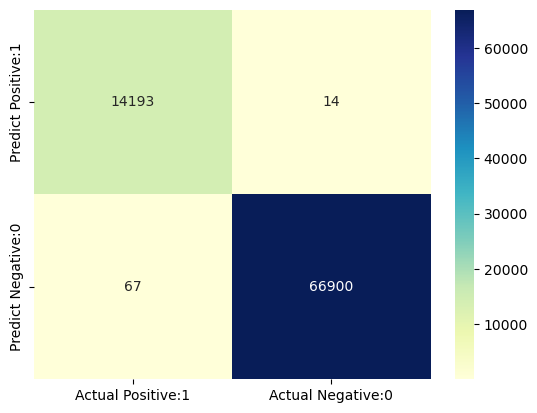

In [58]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

# Classification metrices
### Classification Report

In [59]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14207
           1       1.00      1.00      1.00     66967

    accuracy                           1.00     81174
   macro avg       1.00      1.00      1.00     81174
weighted avg       1.00      1.00      1.00     81174



### Classification accuracy

In [60]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [61]:
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

Classification accuracy : 0.9990


### Classification error

In [62]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('Classification error : {0:0.4f}'.format(classification_error))

Classification error : 0.0010


### Precision

In [63]:
precision = TP / float(TP + FP)


print('Precision : {0:0.4f}'.format(precision))

Precision : 0.9990


### Recall

In [64]:
recall = TP / float(TP + FN)

print('Recall or Sensitivity : {0:0.4f}'.format(recall))

Recall or Sensitivity : 0.9953


### True Positive Rate

In [65]:
true_positive_rate = TP / float(TP + FN)


print('True Positive Rate : {0:0.4f}'.format(true_positive_rate))

True Positive Rate : 0.9953


### False Positive Rate

In [66]:
false_positive_rate = FP / float(FP + TN)


print('False Positive Rate : {0:0.4f}'.format(false_positive_rate))

False Positive Rate : 0.0002


### Specificity

In [67]:
specificity = TN / (TN + FP)

print('Specificity : {0:0.4f}'.format(specificity))

Specificity : 0.9998


# Test Vẽ biểu đồ

Text(0, 0.5, 'Number of pulsar stars')

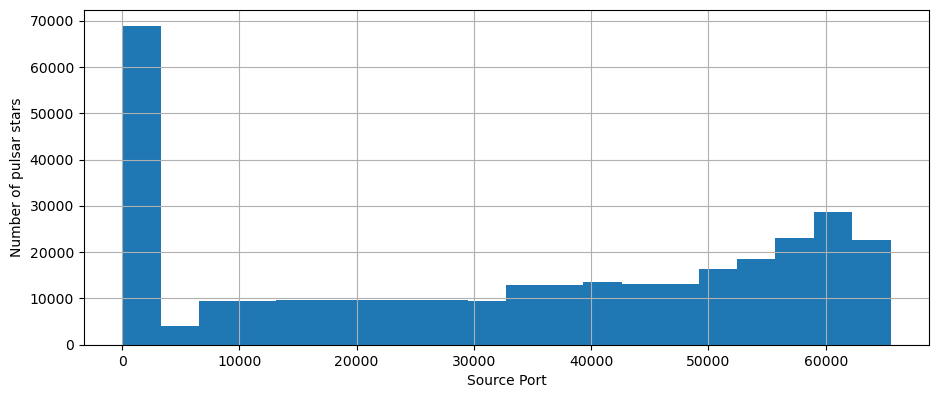

In [68]:
plt.figure(figsize=(24,20))


plt.subplot(4, 2, 1)
fig = df['Source Port'].hist(bins=20)
fig.set_xlabel('Source Port')
fig.set_ylabel('Number of pulsar stars')

Text(0, 0.5, 'Source Port')

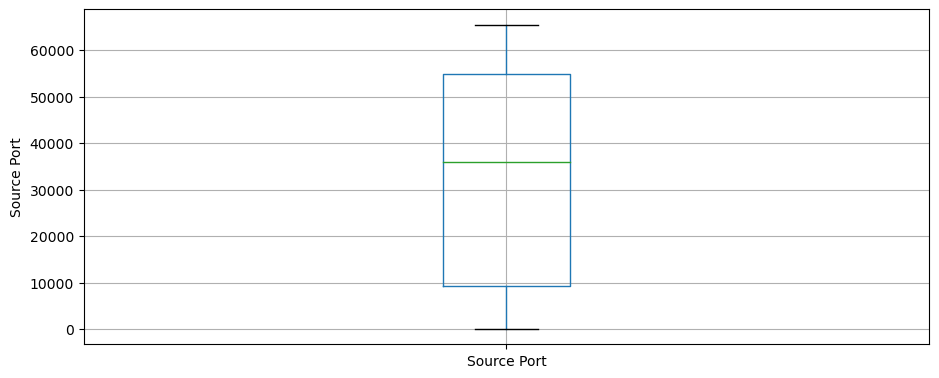

In [69]:
# draw boxplots to visualize outliers

plt.figure(figsize=(24,20))


plt.subplot(4, 2, 1)
fig = df.boxplot(column='Source Port')
fig.set_title('')
fig.set_ylabel('Source Port')